In [85]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set()

In [122]:
D = 500
U = np.random.randn(N,D)
U,_ = np.linalg.qr(U)

In [123]:
U.shape

(1000, 500)

In [146]:
m = 10
P = 20
D = 500
N = 1000
n_avg = 1000

U = np.random.randn(N,D+1)
U,_ = np.linalg.qr(U)
x0 = U[:,-1] / 10
U = U[:,:-1]
errs_proto = []
errs_ex = []
for _ in tqdm(range(n_avg)):
    sa =  U@np.random.randn(D,P) / np.sqrt(D)
    sb = U@np.random.randn(D,P) / np.sqrt(D)

    idxs = np.random.permutation(P)
    xa,ya = np.split(sa[:,idxs],(m,),axis=1)
    xb,yb = np.split(sb[:,idxs],(m,),axis=1)

    # Prototpye
    xabar = xa.mean(1,keepdims=True)
    xbbar = xb.mean(1,keepdims=True)
    h_proto = 1/20 + -((xabar-ya)**2).sum(0) + ((xbbar - ya)**2).sum(0)
    err_proto = (h_proto<0).mean()
    errs_proto.append(err_proto)

    # Exemplar
    da = (((xa[:,:,None] - ya[:,None]))**2).sum(0)
    db = (((xb[:,:,None] - ya[:,None]))**2).sum(0)
    h_ex = 1/20+ -da.mean(0) + db.mean(0)
    err_ex = (h_ex<0).mean()
    errs_ex.append(err_ex)

In [147]:
print(np.mean(errs_proto))
print(np.mean(errs_ex))

0.10980000000000001
0.1559


(array([2., 1., 1., 0., 0., 2., 2., 0., 0., 2.]),
 array([-1.09644605, -1.07796479, -1.05948353, -1.04100227, -1.02252102,
        -1.00403976, -0.9855585 , -0.96707725, -0.94859599, -0.93011473,
        -0.91163348]),
 <a list of 10 Patch objects>)

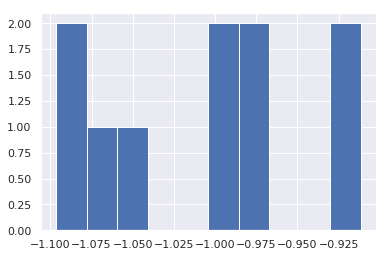

In [139]:
plt.hist(h_proto)

In [136]:
3*np.std(errs_ex) / np.sqrt(n_avg)

0.01786654527321944

In [160]:
m = 25
P = 1000
s = np.random.randn(N,m,P)/np.sqrt(N)
np.mean(((s**2).sum(0).mean(0))**2)

0.9998546742293628

In [161]:
P = 1000
s = np.random.randn(N,m,P)/np.sqrt(N)
np.mean(((s.mean(1)**2).sum(0))**2)

0.001609035513683216

In [162]:
1/m**2

0.0016

In [83]:
np.mean(h_ex<0)

0.0887029288702929

In [72]:
xa.shape

(1000, 5)

In [74]:
ya.shape

(1000, 1195)

In [76]:
(xa[:,:,None] - ya[:,None]).shape

(1000, 5, 1195)

(array([  4.,   6.,  62., 152., 269., 280., 232., 125.,  51.,  14.]),
 array([-0.08095934, -0.05462987, -0.02830039, -0.00197092,  0.02435856,
         0.05068803,  0.07701751,  0.10334698,  0.12967646,  0.15600593,
         0.18233541]),
 <a list of 10 Patch objects>)

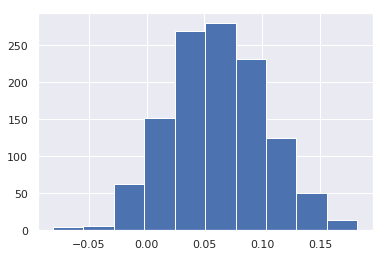

In [70]:
plt.hist(h)

In [58]:
x.shape

(1000, 5)

In [53]:
x.shape

(1000, 5)

In [46]:
m = 5
ss = np.random.choice(s,m,replace=False)

ValueError: a must be 1-dimensional

(array([  1.,  28.,  68., 174., 289., 301., 202., 106.,  24.,   7.]),
 array([-0.00050563,  0.00165056,  0.00380675,  0.00596294,  0.00811914,
         0.01027533,  0.01243152,  0.01458771,  0.0167439 ,  0.01890009,
         0.02105628]),
 <a list of 10 Patch objects>)

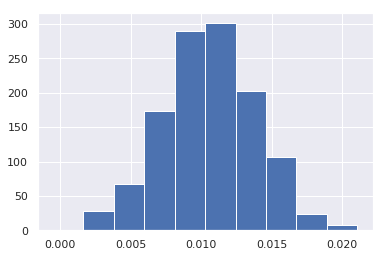

In [43]:
plt.hist(x0@s)

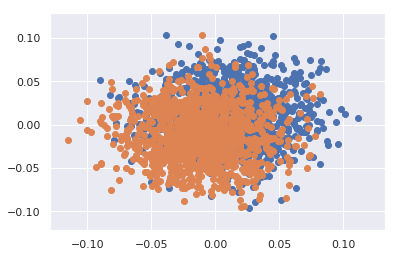

In [31]:
plt.scatter(sa[0],sa[1])
plt.scatter(sb[0],sb[1])

In [9]:
d1 = (s**2).sum(0).mean()
d2 = (s.mean(1)**2).sum(0)
print(d1)
print(d2)

0.9981776597191105
0.0008491640350086041


# Vary beta

In [239]:
m = 10
P = 50
D = 4
N = 5
n_avg = 10000

U = np.random.randn(N,D+1)
U,_ = np.linalg.qr(U)
x0 = U[:,-1] / 5
U = U[:,:-1]
betas = np.logspace(-5,2,10)
errs_proto = []
errs_ex = []
for beta in tqdm(betas):
    for _ in range(n_avg):
        sa = x0[:,None] + U@np.random.randn(D,P) / np.sqrt(D)
        sb = -x0[:,None] + U@np.random.randn(D,P) / np.sqrt(D)

        idxs = np.random.permutation(P)
        xa,ya = np.split(sa[:,idxs],(m,),axis=1)
        xb,yb = np.split(sb[:,idxs],(m,),axis=1)

        # Prototpye
        xabar = xa.mean(1,keepdims=True)
        xbbar = xb.mean(1,keepdims=True)
        h_proto = -((xabar-ya)**2).sum(0) + ((xbbar - ya)**2).sum(0)
        err_proto = (h_proto<0).mean()
        errs_proto.append(err_proto)

        # Exemplar
        da = (((xa[:,:,None] - ya[:,None]))**2).sum(0)
        db = (((xb[:,:,None] - ya[:,None]))**2).sum(0)
        sa = np.exp(-beta*da)
        sb = np.exp(-beta*db)
        h_ex = sa.sum(0) - sb.sum(0)
        err_ex = (h_ex<0).mean()
        errs_ex.append(err_ex)
errs_proto = np.stack(errs_proto).reshape(len(betas), n_avg)
errs_ex = np.stack(errs_ex).reshape(len(betas), n_avg)

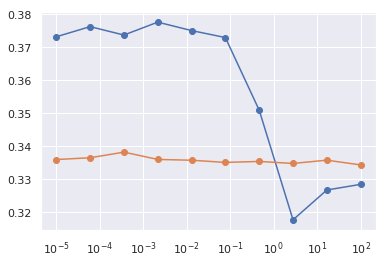

In [240]:
plt.plot(betas, errs_ex.mean(-1), 'o-')
plt.plot(betas, errs_proto.mean(-1), 'o-')
plt.xscale('log')

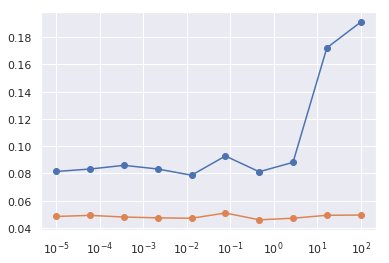

In [236]:
plt.plot(betas, errs_ex.mean(-1), 'o-')
plt.plot(betas, errs_proto.mean(-1), 'o-')
plt.xscale('log')

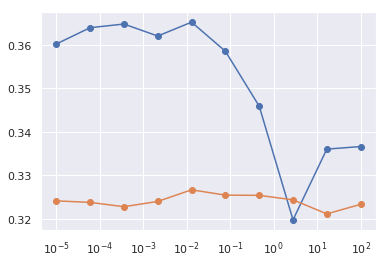

In [234]:
plt.plot(betas, errs_ex.mean(-1), 'o-')
plt.plot(betas, errs_proto.mean(-1), 'o-')
plt.xscale('log')

# Real manifolds

In [901]:
m = 5

from sklearn.neighbors import KNeighborsClassifier
NN = KNeighborsClassifier(n_neighbors=1)

def prototype_learning(m, xa, xb, ya):
    '''Performs a prototype learning experiment, with exponential weighting beta
    Args:
        - m: num training examples
        - xa: (N,m) training examples of object a
        - xb: (N,m) training example of object b
        - ya: (N,P-m) test examples of object a
    '''
    xabar = xa.mean(0,keepdims=True)
    xbbar = xb.mean(0,keepdims=True)
    h_proto = -((xabar-ya)**2).sum(-1) + ((xbbar - ya)**2).sum(-1)
    err_proto = (h_proto<0).mean()
    return err_proto


def exemplar_learning(m, xa, xb, ya, beta, NN=False):
    '''Performs an exemplar learning experiment, with exponential weighting beta
    Args:
        - m: num training examples
        - xa: (N,m) training examples of object a
        - xb: (N,m) training example of object b
        - ya: (N,P-m) test examples of object a
        - beta: Weighting of training examples. b->0 corresponds to equal weighting,
                b->\infty corresponds to 1-NN classifier.
        - NN: bool. Perform 1-NN classification, equivalent to beta->\infty
    '''
    da = (((xa[:,None] - ya[None]))**2).sum(-1)
    db = (((xb[:,None] - ya[None]))**2).sum(-1)
    sa = np.exp(-beta*da)
    sb = np.exp(-beta*db)
    h_ex = sa.sum(0) - sb.sum(0)
    err_ex = (h_ex<=0).mean()
    
    if NN:
        sa = -da.min(0)
        sb = -db.min(0)
        h_ex = sa - sb
        err_ex = (h_ex<=0).mean()
    return err_ex

In [392]:
# manifolds = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/macaque/manifolds_IT.npy')
manifolds_load = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/manifolds.npy',allow_pickle=True)

In [393]:
P = 500
manifolds = []
for manifold in tqdm(manifolds_load):
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [394]:
K = manifolds.shape[0]
P = manifolds.shape[1]
N = manifolds.shape[2]

In [ ]:
n_avg = 50000
betas = np.logspace(-4,-0.9,20)
y = np.concatenate([np.ones(m),-np.ones(m)])
proto_errs = []
ex_errs = []
NN_errs = []
for _ in tqdm(range(n_avg)):
    a,b = np.random.choice(K, 2, replace=False)
    Xa = manifolds[a]
    Xb = manifolds[b]

    perma = np.random.permutation(P)
    permb = np.random.permutation(P)
    xa,ya = np.split(Xa[perma],(m,))
    xb,yb = np.split(Xb[permb],(m,))

    proto_err = prototype_learning(m,xa,xb,ya)
    proto_errs.append(proto_err)
    for beta in betas:
        ex_err = exemplar_learning(m,xa,xb,ya,beta)
        ex_errs.append(ex_err)
    NN_err = exemplar_learning(m,xa,xb,ya,beta,NN=True)
    NN_errs.append(NN_err)
ex_errs = np.stack(ex_errs).reshape(n_avg, len(betas))

Text(0.5, 1.0, 'm=5')

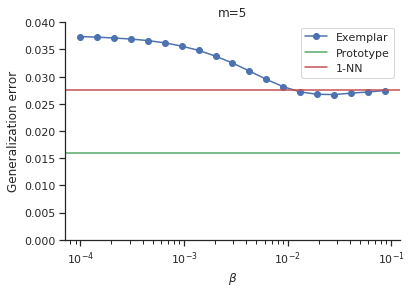

In [493]:
plt.plot(betas[:-1], ex_errs.mean(0)[:-1], 'o-', label='Exemplar')
plt.axhline(np.mean(proto_errs), c='C2', label='Prototype')
plt.axhline(np.mean(NN_errs), c='C3', label='1-NN')
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel('Generalization error')

plt.ylim([0,0.04])
sns.despine()
plt.legend()
plt.title('m='+str(m))
# plt.savefig('images/exemplar_errors_vary_beta.pdf')

## Vary D and m

In [913]:
n_avg = 50000
betas = np.logspace(-4,-0.9,20)
y = np.concatenate([np.ones(m),-np.ones(m)])
proto_errs = []
ex_errs = []
NN_errs = []
ms = np.arange(1,10)
Ds = np.arange(1,100,10)

a,b = np.random.choice(K, 2, replace=False)
Xa = manifolds[a]
Xb = manifolds[b]
Ua,Sa,Va = np.linalg.svd(Xa-Xa.mean(0))
Ub,Sb,Vb = np.linalg.svd(Xb-Xb.mean(0))

for D in tqdm(Ds):
    for m in ms:
        Ya = Ua[:,:D]*Sa[:D]@Va[:D]
        Yb = Ub[:,:D]*Sb[:D]@Vb[:D]

        perma = np.random.permutation(P)
        permb = np.random.permutation(P)
        xa,ya = np.split(Ya[perma],(m,))
        xb,yb = np.split(Yb[permb],(m,))

        proto_err = prototype_learning(m,xa,xb,ya)
        proto_errs.append(proto_err)

        NN_err = exemplar_learning(m,xa,xb,ya,beta,NN=True)
        NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(Ds), len(ms))
NN_errs = np.stack(NN_errs).reshape(len(Ds), len(ms))

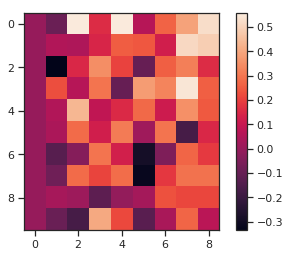

In [915]:
plt.imshow(proto_errs - NN_errs)
plt.colorbar()

# Nearest-neighbors theory

In [874]:
m = 5
ms = np.arange(1,100,5)
N = 500
D = 400
P = 1100
U = np.random.randn(N,D)
U,_ = np.linalg.qr(U)

navg = 10
has = []
hs = []
for m in tqdm(ms):
    for _ in range(navg):
        x0 = np.random.randn(N) / np.sqrt(N)

        sa = np.random.randn(D,m) / np.sqrt(D)
        xa = x0[:,None] + U@sa

        ssa = np.random.randn(D,P) / np.sqrt(D)
        ya = x0[:,None] + U@ssa

        sb = np.random.randn(D,m) / np.sqrt(D)
        xb = -x0[:,None] + U@sb

        da = ((xa[:,None] - ya[:,:,None])**2).sum(0) / 2
        db = ((xb[:,None] - ya[:,:,None])**2).sum(0) / 2

        ha = da.min(-1)
        has.append(ha)
        
        hb = db.min(-1)
        h = -ha + hb
        hs.append(h)
has = np.stack(has).reshape(len(ms),navg,-1)
hs = np.stack(hs).reshape(len(ms),navg,-1)

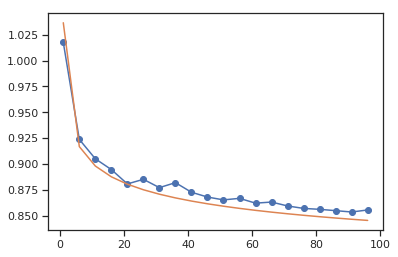

In [875]:
plt.plot(ms,has.mean(-1).mean(-1), 'o-')
sigma = np.sqrt(2/N)
plt.plot(ms,1 - (np.sqrt(2*np.log(ms)) - np.euler_gamma)*sigma)

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


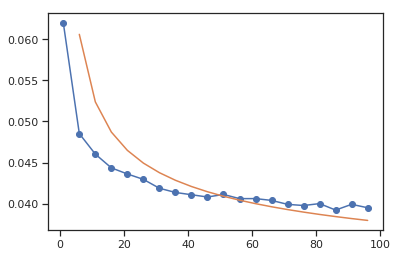

In [884]:
plt.plot(ms,has.std(-1).mean(-1), 'o-')
plt.plot(ms,sigma*np.sqrt(2)/np.sqrt(2*np.log(ms))*np.pi/np.sqrt(6))

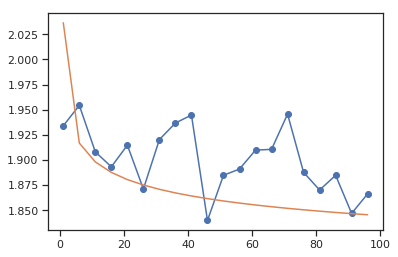

In [885]:
plt.plot(ms,hs.mean(-1).mean(-1), 'o-')
plt.plot(ms,2 - (np.sqrt(2*np.log(ms)) - np.euler_gamma)*sigma)

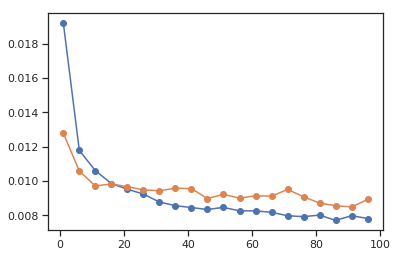

In [892]:
plt.plot(ms,5*has.var(-1).mean(-1), 'o-')
plt.plot(ms,hs.var(-1).mean(-1), 'o-')
# plt.plot(ms,(sigma*np.sqrt(2)/np.sqrt(2*np.log(ms))*np.pi/np.sqrt(6))**2)

In [524]:
h = -da.min(-1) + db.min(-1)

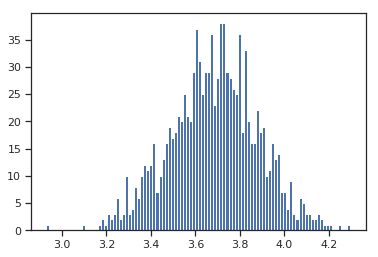

In [529]:
plt.hist(h, bins=100);

In [785]:
Ameans = []
Astds = []
ms = np.logspace(0,3,20, dtype='int')
sigma = 5
for m in tqdm(ms):
    X = np.random.randn(m,1000) * 5
    A = X.max(0)
    Ameans.append(A.mean())
    Astds.append(A.std())

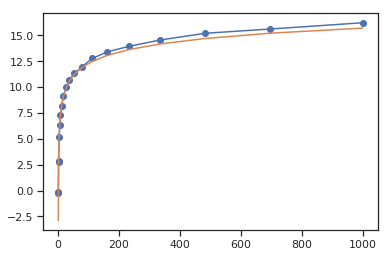

In [787]:
plt.plot(ms,Ameans,'o-')
plt.plot(ms,sigma*(np.sqrt(2*np.log(ms)) - np.euler_gamma))

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


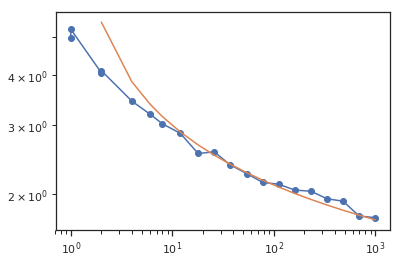

In [788]:
plt.plot(ms,Astds, 'o-')
plt.plot(ms,sigma/np.sqrt(2*np.log(ms))*np.pi/np.sqrt(6))
plt.yscale('log')
plt.xscale('log')

(array([  3.,  35., 110., 202., 284., 229., 165.,  61.,   9.,   2.]),
 array([0.80182787, 0.84403918, 0.88625049, 0.92846179, 0.9706731 ,
        1.01288441, 1.05509571, 1.09730702, 1.13951833, 1.18172963,
        1.22394094]),
 <a list of 10 Patch objects>)

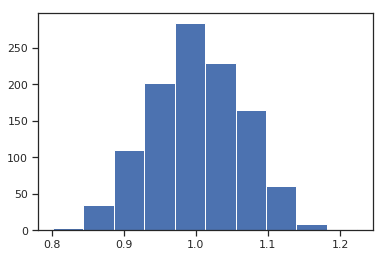

In [791]:
x = np.random.randn(N,P) / np.sqrt(N)
plt.hist((x**2).sum(0))

(array([  7.,  24., 101., 226., 278., 262., 144.,  43.,  12.,   3.]),
 array([-0.14558271, -0.11480508, -0.08402745, -0.05324983, -0.0224722 ,
         0.00830543,  0.03908306,  0.06986069,  0.10063832,  0.13141595,
         0.16219358]),
 <a list of 10 Patch objects>)

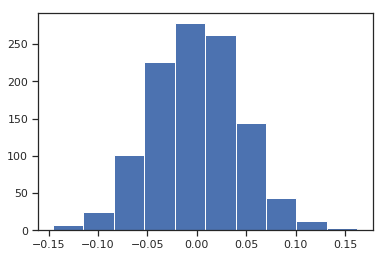

In [800]:
x = np.random.randn(N,P) / np.sqrt(N)
y = np.random.randn(N,P) / np.sqrt(N)
plt.hist((x*y).sum(0))